# Stock Index Time Series

In [ ]:
!pip install yfinance
!pip install --upgrade statsmodels
!pip install prophet

In [ ]:
import os 
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from pprint import pprint

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## The google drive mounting is for using local library

In [ ]:
# Mount your google drive in google colab
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # Insert the directory to syspath
    import sys
    sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks')
except:
    pass

In [ ]:
from time_series_utils import timeseries_evaluation_metrics_func,\
                          create_proph_train_test, find_best_Prophet_model,\
                          find_best_ETS_model, find_best_ARIMA_model, find_best_SARIMAX_model,\
                          load_hyperparam, save_hyperparam

## S&P 500 index (SPY) Time series

In [ ]:
suffix = 'stock_index_SPY'

In [ ]:
ticker = yf.download("SPY", start='2005-01-01')
ticker['Date'] = ticker.index
ticker.head()

[*********************100%***********************]  1 of 1 completed


Open        High         Low       Close  Adj Close  \
Date                                                                    
2005-01-03  121.559998  121.760002  119.900002  120.300003  86.004440   
2005-01-04  120.459999  120.540001  118.440002  118.830002  84.953506   
2005-01-05  118.739998  119.250000  118.000000  118.010002  84.367264   
2005-01-06  118.440002  119.150002  118.260002  118.610001  84.796242   
2005-01-07  118.970001  119.230003  118.129997  118.440002  84.674690   

              Volume       Date  
Date                             
2005-01-03  55748000 2005-01-03  
2005-01-04  69167600 2005-01-04  
2005-01-05  65667300 2005-01-05  
2005-01-06  47814700 2005-01-06  
2005-01-07  55847700 2005-01-07

In [ ]:
ticker.head()

Open        High         Low       Close  Adj Close  \
Date                                                                    
2005-01-03  121.559998  121.760002  119.900002  120.300003  86.004440   
2005-01-04  120.459999  120.540001  118.440002  118.830002  84.953506   
2005-01-05  118.739998  119.250000  118.000000  118.010002  84.367264   
2005-01-06  118.440002  119.150002  118.260002  118.610001  84.796242   
2005-01-07  118.970001  119.230003  118.129997  118.440002  84.674690   

              Volume       Date  
Date                             
2005-01-03  55748000 2005-01-03  
2005-01-04  69167600 2005-01-04  
2005-01-05  65667300 2005-01-05  
2005-01-06  47814700 2005-01-06  
2005-01-07  55847700 2005-01-07

We will focus on the 'Adj Close' in our analysis 

In [ ]:
ticker = ticker[['Adj Close']]
ticker.head() 

Adj Close
Date                 
2005-01-03  86.004440
2005-01-04  84.953506
2005-01-05  84.367264
2005-01-06  84.796242
2005-01-07  84.674690

In [ ]:
ticker = ticker.rename(columns={'Adj Close': 'Adj_Close'})
ticker.tail()

Adj_Close
Date                  
2022-05-05  413.809998
2022-05-06  411.339996
2022-05-09  398.170013
2022-05-10  399.089996
2022-05-11  402.440002

In [ ]:
# fwd fill any NA value
ticker = ticker.ffill()

In [ ]:
# lets change it to weekly
df = ticker.resample(rule='W').sum()
df.tail(), ticker.tail()

(              Adj_Close
 Date                   
 2022-04-17  1759.310028
 2022-04-24  2191.820007
 2022-05-01  2101.690002
 2022-05-08  2085.070007
 2022-05-15  1199.700012,
              Adj_Close
 Date                  
 2022-05-05  413.809998
 2022-05-06  411.339996
 2022-05-09  398.170013
 2022-05-10  399.089996
 2022-05-11  402.440002)

<AxesSubplot:xlabel='Date'>

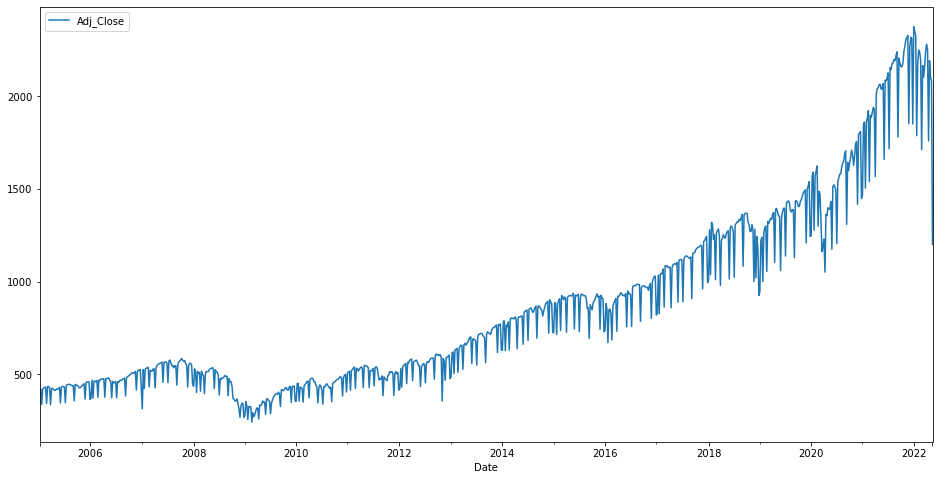

In [ ]:
df.plot(figsize=(16,8))

In [ ]:
df.index

DatetimeIndex(['2005-01-09', '2005-01-16', '2005-01-23', '2005-01-30',
               '2005-02-06', '2005-02-13', '2005-02-20', '2005-02-27',
               '2005-03-06', '2005-03-13',
               ...
               '2022-03-13', '2022-03-20', '2022-03-27', '2022-04-03',
               '2022-04-10', '2022-04-17', '2022-04-24', '2022-05-01',
               '2022-05-08', '2022-05-15'],
              dtype='datetime64[ns]', name='Date', length=906, freq='W-SUN')

In [ ]:
from datetime import datetime, timedelta
train_dataset_end = datetime(2021,5,9)
test_dataset_end = datetime(2022,5,10)

In [ ]:
train_data = df[:train_dataset_end]
test_data = df[train_dataset_end+timedelta(days=7):test_dataset_end]

In [ ]:
prediction_length = len(test_data)
prediction_length

52

Save train data and test data to local storage


In [ ]:
train_data_filename = f'train_data_{suffix}.csv'
test_data_filename = f'test_data_{suffix}.csv'

In [ ]:
train_data.to_csv(train_data_filename, encoding='utf-8')
test_data.to_csv(test_data_filename, encoding='utf-8')

Reload train data and test data from local storage

In [ ]:
train_data = pd.read_csv(train_data_filename, parse_dates=['Date'], index_col='Date')
test_data = pd.read_csv(test_data_filename, parse_dates=['Date'], index_col='Date')

In [ ]:
train2_data = train_data[:-(prediction_length)]
val_data = train_data[-(prediction_length):]

In [ ]:
test_data

Adj_Close
Date                   
2021-05-16  2037.606049
2021-05-23  2041.672668
2021-05-30  2068.588379
2021-06-06  1659.531372
2021-06-13  2086.581543
2021-06-20  2082.690277
2021-06-27  2097.606628
2021-07-04  2126.422607
2021-07-11  1716.908630
2021-07-18  2153.773071
2021-07-25  2144.841125
2021-08-01  2176.568420
2021-08-08  2180.479889
2021-08-15  2197.957611
2021-08-22  2191.808258
2021-08-29  2218.782440
2021-09-05  2239.785400
2021-09-12  1779.254242
2021-09-19  2206.863983
2021-09-26  2178.176971
2021-10-03  2159.868439
2021-10-10  2158.845184
2021-10-17  2177.421967
2021-10-24  2242.083282
2021-10-31  2267.981506
2021-11-07  2306.804108
2021-11-14  2315.615601
2021-11-21  2328.033386
2021-11-28  1851.890564
2021-12-05  2266.451691
2021-12-12  2318.307800
2021-12-19  2313.127808
2021-12-26  1850.580994
2022-01-02  2375.350677
2022-01-09  2350.368286
2022-01-16  2328.296875
2022-01-23  1787.417175
2022-01-30  2174.125854
2022-02-06  2248.524750
2022-02-13  2238.565674
2022-02-20  2196.187286
2022-02-27  1712.250671
2022-03-06  2165.652191
2022-03-13  2102.109528
2022-03-20  2159.053589
2022-03-27  2240.959991
2022-04-03  2280.720032
2022-04-10  2250.689972
2022-04-17  1759.310028
2022-04-24  2191.820007
2022-05-01  2101.690002
2022-05-08  2085.070007

In [ ]:
# Value Columns to be used in all models tuning
value_col = 'Adj_Close'

In [ ]:
# freq, and date_col for Prophet
ph_freq='W' # weekly accumulative
ph_date_col='Date'

## Holt Winters Exponential Smoothings (ETS) Model

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing


In [ ]:
# check seasonal period quarter, or yesrly
best_ETS_RMSE_model, best_RMSE, best_ETS_RMSE_params, best_ETS_WMAPE_model, best_WMAPE, best_ETS_WMAPE_params\
   = find_best_ETS_model(train2_data, val_data, value_col=value_col, seasonal_periods=[13,52])

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packa

In [ ]:
best_RMSE, best_ETS_RMSE_params

(343.6030355205287, ('mul', 'add', 13))

In [ ]:
best_WMAPE, best_ETS_WMAPE_params

(0.18201076761973725, ('mul', 'add', 13))

(343.60311227190124, ('mul', 'add', 13))

We forward forecast with full train data. 

In [ ]:
trend, seasonal, seasonal_period = best_ETS_RMSE_params

ETS_model_updated = ExponentialSmoothing(train_data[value_col], trend=trend, seasonal=seasonal,\
                                         seasonal_periods=seasonal_period).fit()

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
test_pred_ETS = ETS_model_updated.forecast(len(test_data))
test_pred_ETS

2021-05-16    2053.610895
2021-05-23    1959.273412
2021-05-30    1972.881611
2021-06-06    2043.310519
2021-06-13    2057.328456
2021-06-20    2076.332848
2021-06-27    1995.603338
2021-07-04    1948.406217
2021-07-11    2121.020303
2021-07-18    2136.721233
2021-07-25    2105.040866
2021-08-01    2172.254669
2021-08-08    2182.374607
2021-08-15    2191.572409
2021-08-22    2097.919371
2021-08-29    2112.215411
2021-09-05    2183.335571
2021-09-12    2198.048191
2021-09-19    2217.750712
2021-09-26    2137.722794
2021-10-03    2091.230746
2021-10-10    2264.553402
2021-10-17    2280.966418
2021-10-24    2250.001671
2021-10-31    2317.934643
2021-11-07    2328.777318
2021-11-14    2338.701443
2021-11-21    2245.778331
2021-11-28    2260.807917
2021-12-05    2332.665265
2021-12-12    2348.118728
2021-12-19    2368.565768
2021-12-26    2289.286063
2022-01-02    2243.545940
2022-01-09    2417.624252
2022-01-16    2434.796672
2022-01-23    2404.595096
2022-01-30    2473.295026
2022-02-06  

In [ ]:
test_data['Predicted_ETS'] = test_pred_ETS

<AxesSubplot:xlabel='Date'>

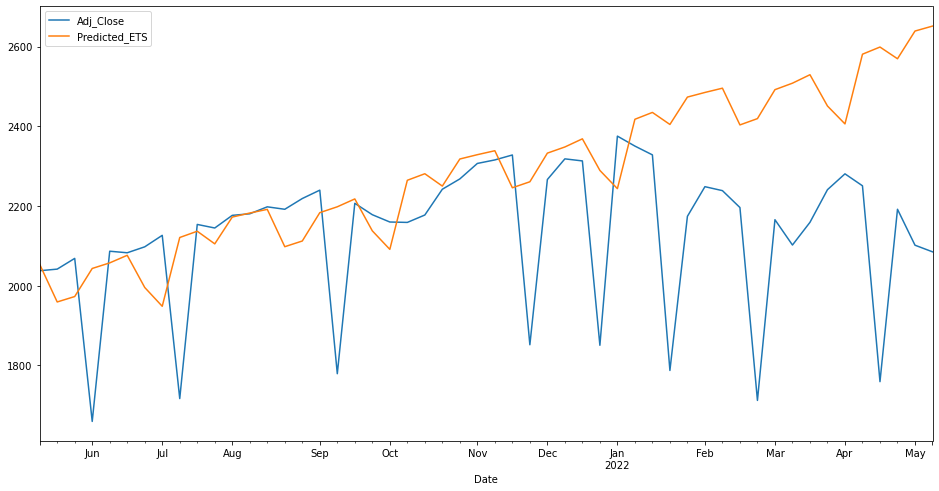

In [ ]:
test_data[[value_col, 'Predicted_ETS']].plot(figsize=(16,8))

## ARIMA Model

In [ ]:
## create an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
arima_model_filename = f"arima_{suffix}_hyper_params"

In [ ]:
best_params = None 
try:
    best_params = load_hyperparam(arima_model_filename)
except:
    pass 

In [ ]:
# # force hyperparameter recalculation
# best_params = None 

We search for best hyperparameters with train2 data and val data.

In [ ]:
best_ARIMA_RMSE_model, best_RMSE, best_pdq_RMSE,\
best_ARIMA_WMAPE_model, best_WMAPE, best_pdq_WMAPE\
    = find_best_ARIMA_model(train2_data, val_data, value_col=value_col, best_params=best_params)

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [ ]:
best_pdq_RMSE, best_RMSE

((1, 1, 0), 356.71145258919677)

In [ ]:
# save best hyper params to file 
save_hyperparam(arima_model_filename, best_pdq_RMSE)

In [ ]:
best_pdq_WMAPE, best_WMAPE

((1, 1, 0), 0.18140397286193868)

Update the model with full train data.

In [ ]:
model_ARIMA = ARIMA(train_data[value_col], order=best_pdq_RMSE).fit()

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [ ]:
test_pred_arima = model_ARIMA.predict(start=test_data.index[0], end=test_data.index[-1])

In [ ]:
test_data['Predicted_ARIMA'] = test_pred_arima

<AxesSubplot:xlabel='Date'>

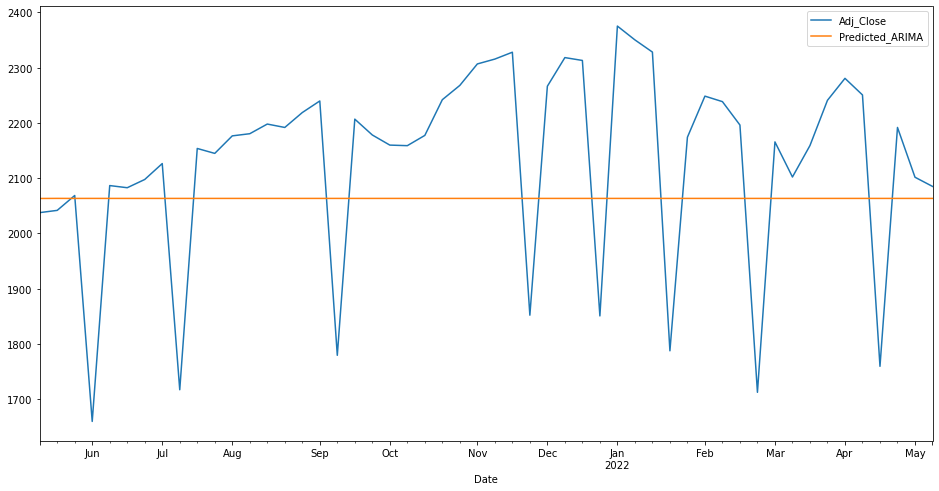

In [ ]:
test_data[[value_col, 'Predicted_ARIMA']].plot(figsize=(16,8))

## SARIMAX Model

In [ ]:
# create a SARIMAX model 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
sarimax_model_filename = f"sarimax_{suffix}_hyper_params"

In [ ]:
# remove after 1 run 
best_params = (2, 1, 1, 52)
save_hyperparam(sarimax_model_filename, best_params)

In [ ]:
best_params = None 
try:
    best_params = load_hyperparam(sarimax_model_filename)
except:
    pass 

In [ ]:
# # force hyperparams recalculation
# best_params = None 

In [ ]:
# we get best pdq from ARIMA (=best_pdq) and seaonal_period from ETS best params
seasonal_period = best_ETS_RMSE_params[2]
best_pdq = best_pdq_RMSE

We find hyperparameters with trains2 and validation data.

In [ ]:
best_SARIMAX_model, best_RMSE, best_PDQS = find_best_SARIMAX_model(train2_data, val_data, best_pdq, \
                                                                  value_col=value_col, season_period=seasonal_period,\
                                                                   best_params=best_params)

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.26483D+00    |proj g|=  9.60938D-02

At iterate    5    f=  5.25048D+00    |proj g|=  3.76694D-02

At iterate   10    f=  5.24718D+00    |proj g|=  1.82541D-03

At iterate   15    f=  5.24578D+00    |proj g|=  1.98882D-02

At iterate   20    f=  5.24219D+00    |proj g|=  2.46431D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     24      1     0     0   2.070D-05   5.242D+00
  F =   5.2421892309904106     

CONVERG

In [ ]:
best_RMSE, best_PDQS

(338.34453862868514, (2, 1, 1, 52))

In [ ]:
# save best hyperparams to file 
save_hyperparam(sarimax_model_filename, best_PDQS)

best_RMSE, best_PDQS

(355.811103138477, (2, 1, 1, 52))

We train model with full train data.

In [ ]:
model_SARIMAX = SARIMAX(train_data[value_col], order=best_pdq_RMSE, seasonal_order=best_PDQS).fit()

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.37434D+00    |proj g|=  9.67586D-02


 This problem is unconstrained.



At iterate    5    f=  5.36288D+00    |proj g|=  4.10850D-02

At iterate   10    f=  5.36082D+00    |proj g|=  1.35103D-03

At iterate   15    f=  5.36016D+00    |proj g|=  1.38230D-02

At iterate   20    f=  5.35768D+00    |proj g|=  6.91446D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     25      1     0     0   1.155D-05   5.358D+00
  F =   5.3576740160042942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [ ]:
pred_test_SARIMAX = model_SARIMAX.predict(start=test_data.index[0], end=test_data.index[-1])

In [ ]:
test_data['Predicted_SARIMAX'] = pred_test_SARIMAX

<AxesSubplot:xlabel='Date'>

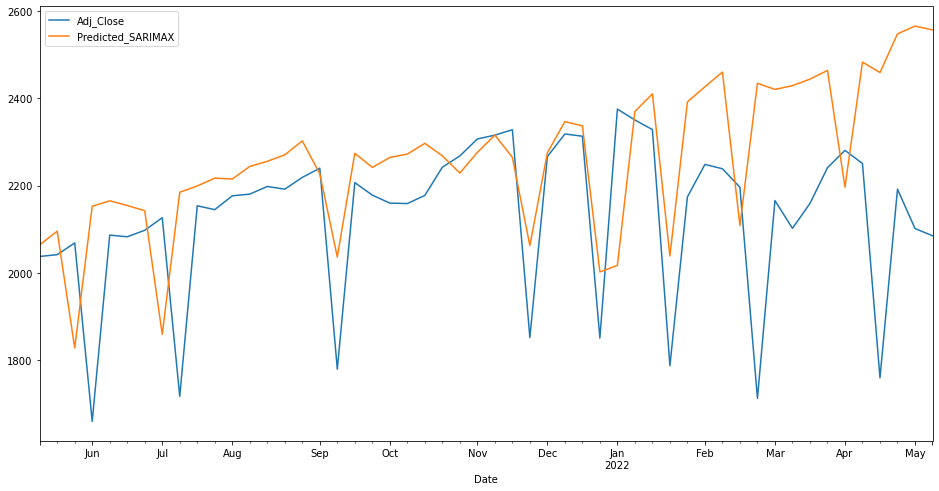

In [ ]:
test_data[[value_col, 'Predicted_SARIMAX']].plot(figsize=(16,8))

## Prophet

In [ ]:
from prophet import Prophet

In [ ]:
prophet_model_filename = f"prophet_{suffix}_hyper_params"

In [ ]:
best_params = None 
try:
    best_params = load_hyperparam(prophet_model_filename)
except:
    pass 

In [ ]:
# # force hyperparam recalculation
# best_params = None

In [ ]:
proph_train2, proph_val = create_proph_train_test(train2_data, val_data, date_col=ph_date_col, value_col=value_col)
proph_train, proph_test = create_proph_train_test(train_data, test_data, date_col=ph_date_col, value_col=value_col)

Find the best hyperparameters with train2 and validation data.

In [ ]:
best_Prophet_RMSE_model, best_RMSE, best_Prophet_RMSE_params,\
best_Prophet_WMAPE_model, best_WMAPE, best_Prophet_WMAPE_params\
    = find_best_Prophet_model(proph_train2, proph_val, val_data, value_col=value_col, freq=ph_freq, best_params=best_params)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2020.84    0.00552915       80.8253       1.812      0.1812      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2027.22   0.000159132       59.4746      0.5109      0.5109      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       2027.31   0.000273629       87.3304   4.119e-06       0.001      305  LS failed, Hessian reset 
     251       2027.52   0.000148648       95.1274   1.173e-06       0.001      393  LS failed, Hessian reset 
     299       2027.68   6.27061e-05        66.213      0.6019      0.6019      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       2027.69   0.000153401       68.2703   2.121e-06       0.001      496  LS failed, Hessian rese

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.966182664859079
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2032.72    0.00414675       130.438           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2041.14   0.000155478       80.2182      0.2571      0.2571      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       2041.56   0.000136839       88.8491   1.002e-06       0.001      360  LS failed, Hessian reset 
     275       2041.83   4.81797e-05       53.9027   8.053e-07       0.001      444  LS failed, Hessian reset 
     299       2041.88   5.08677e-05       76.9763           1           1      473   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       2043.27   0.000251691       149.706   9.345e-07     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.024331531112848
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2021.16   0.000709904       671.083     0.08229     0.08229      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158        2024.9   0.000332339       141.004   8.735e-07       0.001      230  LS failed, Hessian reset 
     199       2026.71   0.000798634       103.665           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205        2026.8     0.0008836       219.124   1.351e-05       0.001      321  LS failed, Hessian reset 
     242       2027.07   0.000663617       175.936   5.407e-06       0.001      400  LS failed, Hessian reset 
     275       2027.29   3.96062e-05       63.6586   7.258e-07       0.001      475  LS failed, Hessian reset 
     299       2027.29  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.959589708755137
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2031.23    0.00763195       167.767           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2041.21   0.000386765       108.271      0.8656      0.8656      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2043.33     0.0148252       174.999           1           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     308        2043.7   0.000157365        87.572   8.274e-07       0.001      418  LS failed, Hessian reset 
     346       2045.05   0.000357027       98.3165   7.107e-06       0.001      500  LS failed, Hessian reset 
     399       2045.36   0.000122992       69.2059      0.6961     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.996543338371616
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2019.24     0.0193994         176.1           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2025.94    0.00318328       71.8146           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       2027.57   0.000306862       121.324   4.206e-06       0.001      388  LS failed, Hessian reset 
     299       2027.71   8.85895e-05       67.3211       0.764       0.764      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     309       2027.73    0.00010351       68.6557   1.657e-06       0.001      457  LS failed, Hessian reset 
     389       2029.49   0.000145194       95.3829   1.572e-06     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.981858446865823
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2033.05    0.00762751       249.079           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2040.93   0.000632474       106.693      0.6877      0.6877      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       2041.38   0.000290786       150.902   3.764e-06       0.001      313  LS failed, Hessian reset 
     299       2041.84   8.32737e-05       58.5256      0.7522      0.7522      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2042.73   0.000129119        104.25      0.6274      0.6274      523   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.985561847524737
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2052.33    0.00360355       153.418           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       2062.75   0.000163243       113.599   1.211e-06       0.001      233  LS failed, Hessian reset 
     199       2064.66    0.00710712       120.373      0.6535      0.6535      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2067.01    0.00231186        130.87      0.8265      0.8265      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       2067.08   0.000139163       87.0582   1.021e-06       0.001      437  LS failed, Hessian reset 
     399       2072.03     0.0039438        153.96           1     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.803716744494865
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2071.66     0.0494235        98.789      0.6004      0.6004      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       2080.44   0.000397173       137.351   1.064e-05       0.001      251  LS failed, Hessian reset 
     199       2081.38   0.000361628        107.48      0.5758      0.5758      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       2081.83   0.000204378       116.745   2.891e-06       0.001      333  LS failed, Hessian reset 
     299       2084.57    0.00102988       86.5342           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2088.09    0.00317846       51.3915           1     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.835489537115405
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2055.15    0.00323363        519.52      0.5396      0.5396      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2064.79    0.00414377       89.8345           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       2065.76   0.000158778        84.788     8.5e-07       0.001      333  LS failed, Hessian reset 
     299       2067.19    0.00118086       155.051      0.4978           1      407   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       2070.33   0.000257043       161.295   1.457e-06       0.001      513  LS failed, Hessian reset 
     399        2072.7    0.00302244       105.172           1     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.781227202464934
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2065.3     0.0019066       338.387     0.09204           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2080.32    0.00337882       98.5195           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2086.33    0.00420958       162.703           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     377       2088.63   8.31197e-05       62.0636   1.448e-06       0.001      499  LS failed, Hessian reset 
     399       2088.77   0.000637155       40.2237      0.4314           1      528   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.843970799619798
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2050.23     0.0258223       444.623           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2063.9    0.00546966       126.903           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     295       2069.24   0.000126377       92.4165   1.432e-06       0.001      386  LS failed, Hessian reset 
     299       2070.29    0.00117702       78.9861      0.8566      0.8566      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2073.09   0.000315234       31.9539       0.481       0.481      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.789807936828376
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2065.11     0.0131327       215.278      0.9343      0.9343      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2081.69    0.00184485       106.031           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       2082.61    0.00013777        82.061   3.296e-06       0.001      313  LS failed, Hessian reset 
     299       2085.33    0.00136054       133.186      0.3448      0.3448      405   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        2088.2    0.00150271       85.7254           1           1      538   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.838565571509918
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2093.32     0.0567565       398.676           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2110.2    0.00990352       70.1051           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2115.72    0.00407411       55.5584           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       2116.24   3.34372e-05       22.8031   2.466e-06       0.001      452  LS failed, Hessian reset 
     376        2116.3   1.89026e-05       14.4422    1.42e-06       0.001      509  LS failed, Hessian reset 
     399       2116.36   0.000126221       19.5126           1     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.97533393939528
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2102.67      0.053406       574.829           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2119.85    0.00503474       119.031      0.8086      0.8086      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2130.06    0.00811332       203.843      0.5681      0.5681      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2132.33     0.0375375       297.606           1           1      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     484       2133.07   3.30315e-05       25.8173   1.512e-06       0.001      631  LS failed, Hessian reset 


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.06613353810282
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2085.97    0.00709734       342.448      0.9797      0.9797      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2107.79     0.0104794       130.289           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2114.12    0.00108988       111.494      0.3336      0.3336      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2116.37    0.00176635       22.7645           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     405       2116.39   4.90978e-05        35.429   1.451e-06       0.001      505  LS failed, Hessian reset 


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.981396638332372
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2092.41    0.00935398       438.333           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2124.92     0.0210219       268.962           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2129.63    0.00472794       33.5662           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     361       2131.61   7.61363e-05       58.4683   1.446e-06       0.001      457  LS failed, Hessian reset 
     399       2132.33    0.00744597       30.9584           1           1      504   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.04564779848577
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2086.91    0.00145482       309.435      0.9059      0.9059      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2108.68    0.00487639        109.76           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2112.09    0.00281645       131.117           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2115.53    0.00670942       17.7287           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2116.81     0.0170354         38.23           1           1      587   
    Iter      log prob  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.990991987328747
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2109.32    0.00430343       218.596      0.1732      0.9758      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2124.18     0.0145915       400.533           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        2128.3     0.0327336       59.6698      0.2688           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2131.61    0.00494595        101.86           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2132.76     0.0105795       33.6736           1           1      604   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.071204660204559
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2083.89    0.00284598       194.687           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2118.92     0.0026007       103.292      0.3423      0.3423      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2125.36     0.0437696       557.002           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2128.57    0.00115369       41.7671      0.2564           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2130.5     0.0112084       188.748      0.9604      0.9604      572   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.055113168451927
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2098.89     0.0259705       219.984           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2132.86    0.00700905       108.216           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2142.83    0.00058724       37.8041           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2147.14    0.00143202       58.9741      0.4614      0.4614      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2148.16    0.00622991       71.4291           1           1      571   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.129638327285337
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2089.46     0.0435894       670.775           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2115.51    0.00255848       145.804           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2124.67    0.00505688       54.3967           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2127.41    0.00445111       49.3655           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2129.9   0.000117719       14.2762       0.789       0.789      575   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.0626112921414785
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2116.64    0.00156492       200.825           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2139.79     0.0127393       1066.62      0.4014      0.4014      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2144.84    0.00595682       93.6419       1.482      0.1482      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2147.27   0.000138191       26.4512           1           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2148.27    0.00362554       47.2194           1           1      580   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.128281883049757
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2084.4      0.016107         129.8           1           1      111   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2119.67     0.0161158       191.325      0.4557      0.4557      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2127.39    0.00169976       108.716      0.1579      0.1579      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2130.39    0.00120223       31.0458           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2131.52     0.0187263       22.1553           1           1      569   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.067590074963402
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2108.47     0.0690298       1304.64           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2133.24     0.0197589       212.538           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2143.51    0.00561241       145.664      0.6562      0.6562      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2147.47   0.000808949       21.6196           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2149.02    0.00356515       19.7527           1           1      586   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.125953802995101
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2018.37     0.0031337        168.48      0.8834      0.8834      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2025.73    0.00108333       112.625      0.4837      0.4837      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       2028.51   0.000165165       94.6888   1.214e-06       0.001      340  LS failed, Hessian reset 
     299       2029.62   0.000444366        50.063      0.7738      0.7738      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     351       2029.82   0.000390069       78.9369   4.655e-06       0.001      521  LS failed, Hessian reset 
     399       2030.28   4.29222e-05       72.3763           1     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.953224182644853
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        2032.3    0.00811101       103.193           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2041.1    0.00178227        136.81       1.962     0.01962      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       2041.52   0.000155682       68.9351   1.812e-06       0.001      344  LS failed, Hessian reset 
     288       2043.05    0.00134508       308.909    6.75e-06       0.001      436  LS failed, Hessian reset 
     299       2043.33    0.00109564       182.528           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       2043.61   0.000105152       74.9766    1.12e-06     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.024476049809863
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       2015.78   0.000169717        93.718   1.347e-06       0.001      131  LS failed, Hessian reset 
      99       2019.72    0.00931663       96.0992           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116        2022.3   0.000212734       107.689   3.131e-06       0.001      213  LS failed, Hessian reset 
     142       2023.64   0.000156894       92.3171   2.622e-06       0.001      282  LS failed, Hessian reset 
     199          2026   0.000900838       84.8276      0.5229      0.5229      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       2027.65    0.00104634       111.621   1.188e-05       0.001      420  LS failed, Hessian reset 
     299       2029.44  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.950662676856357
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2031.37      0.019851       105.899           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       2039.13   0.000365557       128.258   8.725e-07       0.001      269  LS failed, Hessian reset 
     199        2040.2   0.000513277       133.584      0.7675      0.7675      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       2042.57   0.000515628       100.447   8.233e-07       0.001      407  LS failed, Hessian reset 
     297       2043.92   0.000337728       106.488   4.214e-06       0.001      487  LS failed, Hessian reset 
     299       2043.93   4.78644e-05       56.4892      0.7899      0.7899      489   
    Iter      log prob        ||dx||      ||grad

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.998230376194016
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2017.97     0.0265797       309.546           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2025.21    0.00841631       104.233           1           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       2029.22   0.000143146       112.123   1.706e-06       0.001      399  LS failed, Hessian reset 
     299       2029.25   3.64187e-05       71.0837           1           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320       2029.28   7.55152e-05        73.467   1.027e-06       0.001      494  LS failed, Hessian reset 
     350       2029.29   0.000184468        116.28    1.89e-06     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  6.973196098821751
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2032.45    0.00831386       232.841      0.9183      0.9183      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       2039.45   0.000199697       110.263   1.023e-06       0.001      274  LS failed, Hessian reset 
     199       2040.24    0.00145088       77.0607           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2043.77   5.88161e-05       73.6839       0.333       0.333      420   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       2044.19   0.000718041       229.933   7.906e-06       0.001      511  LS failed, Hessian reset 
     399       2044.37   4.94822e-05       61.5214      0.3467     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.010409618877832
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2054.69     0.0168696       324.569           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       2066.95   8.92319e-05         47.54    9.43e-07       0.001      254  LS failed, Hessian reset 
     199        2069.3     0.0146965       176.884           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2071.84   0.000582783       185.629      0.5218      0.5218      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       2072.94   0.000142158       87.2307   1.135e-06       0.001      517  LS failed, Hessian reset 
     399       2073.87    0.00051516       57.8886           1     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.343287112553924
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2073.66    0.00153496       88.4758           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2085.25    0.00201289       181.369       0.565       0.565      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2087.91    0.00058899       40.3818           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2088.87    0.00110296       89.5643      0.4075      0.4075      492   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     405       2089.26   0.000140933       75.6909   8.453e-07       0.001      550  LS failed, Hessian reset 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.416979215617764
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2051.67    0.00425514       87.9977      0.3567      0.3567      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       2065.95   0.000229677       98.3647   4.019e-06       0.001      248  LS failed, Hessian reset 
     199       2067.48    0.00175548       121.891      0.2816           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2071.62   0.000107851       61.8548   2.145e-06       0.001      453  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     362       2072.65   9.58184e-05       56.2326   2.327e-06       0.001      569  LS failed, Hessian reset 
     399       2072.88      0.013617       

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.236444739826821
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2066.47    0.00856263       127.684           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2084.1     0.0136135       218.337      0.2692           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2088.05   0.000409841       42.0821      0.5576      0.5576      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     387       2089.21    0.00017636        115.02   9.681e-07       0.001      520  LS failed, Hessian reset 
     399       2089.64    0.00108883       93.5962           1           1      532   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.443427457218593
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2052.34    0.00275298       348.433      0.1923      0.1923      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2066.96    0.00730858       281.577           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2070.46   0.000179896       34.5742      0.2385           1      367   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       2070.85   0.000198208        106.23   2.467e-06       0.001      442  LS failed, Hessian reset 
     399       2072.85     0.0184682       196.721           1           1      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.326599221189904
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2065.77    0.00467293       108.944           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2083.98    0.00509296       91.3892           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2087.82   0.000930345       52.3112           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       2088.16   6.62366e-05        45.191   1.103e-06       0.001      420  LS failed, Hessian reset 
     394       2089.05   0.000123485       85.6805   1.173e-06       0.001      568  LS failed, Hessian reset 
     399       2089.21    0.00153927       48.4883           1     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.409071283791876
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2088.86     0.0203325       223.876           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2114.51     0.0109947       191.603      0.2144      0.8568      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2120.42     0.0407118       107.368           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2121.46    0.00421022       116.619           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2122.35   0.000743827       34.1875      0.9315      0.9315      568   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.6635655426217095
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2103.63     0.0265157       951.258      0.4427      0.4427      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2123.62     0.0033995       93.2491           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2135.34   0.000419653       87.7692      0.2406      0.2406      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2137.67    0.00117278       45.1602           1           1      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2138.8    0.00412186        22.931           1           1      580   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.707568068835323
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2093.93     0.0908538       398.041           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2113.96    0.00889597       385.099           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2119.16    0.00346162       34.5297           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2120.77    0.00283136       135.235      0.5092           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2121.87     0.0224285       96.0075           1           1      586   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.683440372186941
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2102.75     0.0195436        411.55           1           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2127.08   0.000814929       43.1772           1           1      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2136.07     0.0129824       35.7855           1           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          2138     0.0166257       191.178           1           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     463       2138.83   0.000257091       43.0943   1.283e-05       0.001      568  LS failed, Hessian reset 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.698209867545485
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2084.72    0.00876737       441.987      0.3786      0.3786      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2109.44   0.000902741       130.704           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2117.29     0.0937541       268.237           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2121.44   0.000248051       50.8705      0.2289      0.2289      472   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        2122.7   0.000318685       27.7619        0.26        0.26      587   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.660873903508103
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2101.37    0.00972776       1076.12      0.2356     0.02356      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2129.19    0.00798382       63.2517           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2135.19    0.00454036         63.41           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2138.23    0.00366887       54.6121      0.4369           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          2139   0.000327542       46.7134           1           1      580   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.702776931459757
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2096.87     0.0993565       657.137           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2126.6     0.0684117        157.18           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2134.32    0.00154605       42.4804           1           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2135.81    0.00572252       32.6213           1           1      455   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2137.01     0.0126375       40.9762      0.8203      0.8203      568   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.592547401877197
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2113.25     0.0375525       481.723           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2142.82    0.00390368       96.0439           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2150.64    0.00167014       138.948      0.5919      0.5919      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2153.26     0.0441314       45.9129           1           1      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2154.03   0.000424574       19.3538           1           1      597   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.516711987677805
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2096.54     0.0960982       255.313           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        2123.6     0.0201505        249.37           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2134.87     0.0034529       59.8631      0.5284      0.5284      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2135.79     0.0100698       78.4779           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2137.29    0.00220673       67.6534      0.2319      0.2319      574   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.6160271461069895
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2112.22    0.00743194       302.312           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2143.24    0.00414079       93.1556           1           1      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2149.75    0.00176774       132.526      0.5955      0.5955      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2151.62    0.00687806       60.1217           1           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2153.08    0.00606051       99.4329           1           1      597   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.539856623766402
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2096.57      0.022846       163.089           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2125.34     0.0241979       169.328           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2133.77     0.0208844       112.518           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2135.62    0.00953533       20.4453           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2136.87    0.00157822        38.626           1           1      561   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  7.5936000274088205
Initial log joint probability = -10.4042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2114.18      0.065236       812.773           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2143.16     0.0161304       273.001           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2151.07    0.00555595       36.0488           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       2152.99     0.0012112       39.9679      0.2231           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       2154.13   0.000510873       24.2126      0.4847      0.4847      565   
    Iter      log prob

In [ ]:
best_Prophet_RMSE_params, best_RMSE

((0.8, 0.1, 2, 'additive'), 245.55302366188744)

In [ ]:
# save best hyper params to file 
save_hyperparam(prophet_model_filename, best_Prophet_RMSE_params)

In [ ]:
best_Prophet_WMAPE_params, best_WMAPE

((0.8, 0.1, 2, 'additive'), 6.781227202464934)

best_Prophet_RMSE_params, best_RMSE

((0.9, 0.5, 10, 'additive'), 363.9029597459869)

best_Prophet_WMAPE_params, best_WMAPE

((0.9, 0.5, 10, 'additive'), 10.92341902599812)


We retrain with full train data.

In [ ]:
changepoint_range, changepoint_prior_scale, seasonality_prio_scale, seasonality_mode = best_Prophet_RMSE_params

In [ ]:
model_Prophet = Prophet(changepoint_range=changepoint_range,\
                    changepoint_prior_scale=changepoint_prior_scale,\
                    seasonality_prior_scale=seasonality_prio_scale,\
                    seasonality_mode=seasonality_mode)
model_Prophet.fit(proph_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -27.7444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2245.52    0.00777951       205.367           1           1      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       2257.52   0.000167358       95.6183    3.06e-06       0.001      269  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       2259.36   0.000118613       66.7451    6.64e-07       0.001      357  LS failed, Hessian reset 
     299       2261.18     0.0012867       83.0471           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     330        2261.6   0.000115985       89.8362   1.487e-06       0.001      501  LS failed, Hessian reset 
     355        2261.9   4.96654e-05       40.2972   9.576e-07       0.001      571 

-07       29.9377     0.01061           1     1168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [ ]:
future = model_Prophet.make_future_dataframe(periods=len(proph_test), freq=ph_freq)
forecast = model_Prophet.predict(future)

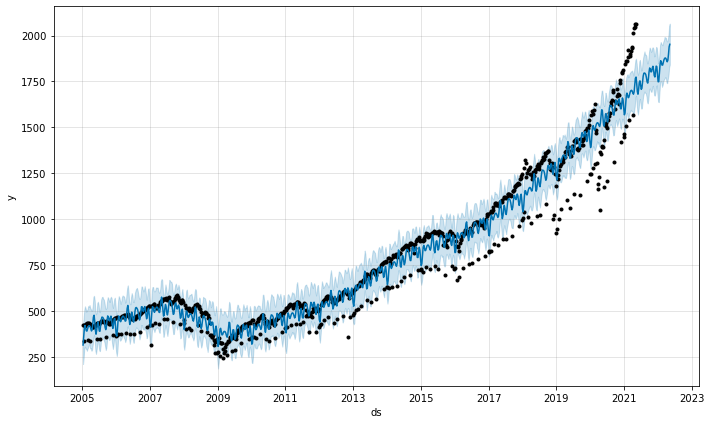

In [ ]:
fig1 = model_Prophet.plot(forecast)

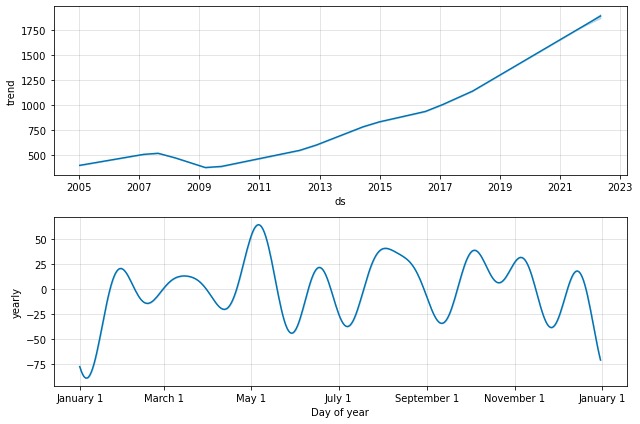

In [ ]:
fig2 = model_Prophet.plot_components(forecast)

In [ ]:
test_data['Predicted_Prophet'] = forecast[-(len(proph_test)):][['ds', 'yhat']].set_index('ds')

<AxesSubplot:xlabel='Date'>

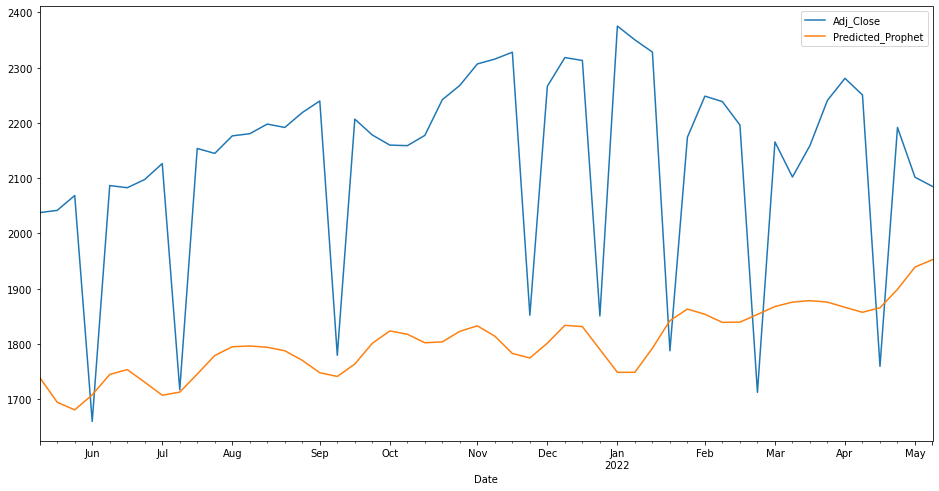

In [ ]:
test_data[[value_col, 'Predicted_Prophet']].plot(figsize=(16,8))

## Metrics

In [ ]:
test_data = test_data.ffill(axis=0)

In [ ]:
timeseries_evaluation_metrics_func(test_data.Adj_Close, test_data.Predicted_ETS)

Evaluation metric results:-
Mean Square Error is : 80380.37107884728
Mean Absolute Error is : 197.59213042030672
Root Mean Square Error is : 283.5143225285934
Mean Absolute Percentage Error is : 9.957155052337358
R2 score is : -1.5575689045362648

Weighted MAPE: 0.09265660765571103


In [ ]:
timeseries_evaluation_metrics_func(test_data.Adj_Close, test_data.Predicted_ARIMA)

Evaluation metric results:-
Mean Square Error is : 36214.3842070715
Mean Absolute Error is : 162.90957318468185
Root Mean Square Error is : 190.30077300702564
Mean Absolute Percentage Error is : 7.830831676813296
R2 score is : -0.15228110671548212

Weighted MAPE: 0.07639296349416312


In [ ]:
timeseries_evaluation_metrics_func(test_data.Adj_Close, test_data.Predicted_SARIMAX)

Evaluation metric results:-
Mean Square Error is : 59623.95727214595
Mean Absolute Error is : 173.84265092473467
Root Mean Square Error is : 244.18017379006417
Mean Absolute Percentage Error is : 8.710925528649087
R2 score is : -0.8971345496160432

Weighted MAPE: 0.08151979669584286


In [ ]:
timeseries_evaluation_metrics_func(test_data.Adj_Close, test_data.Predicted_Prophet)

Evaluation metric results:-
Mean Square Error is : 139586.33723069716
Mean Absolute Error is : 342.65841414954417
Root Mean Square Error is : 373.61254961617277
Mean Absolute Percentage Error is : 15.602355345194379
R2 score is : -3.4414036761431612

Weighted MAPE: 0.160682341813141


### Conclusion: 

Based on WMAPE value, the ARIMA model provide the best prediction.
Ranking of the models are: ARIMA, SARIMAX, ETS and Prophet